## **2025 Data Creator Camp**
같이DATA TEAM: Mission 4 (Data Analysis)

---

 이 ipynb는 Mission 4-1 MultiModal Segmentation에서  사용할 Input Normalization과 Data Oversampling을 사전에 분석 및 설계하기 위한 보조 ipynb입니다. <br>

  메인 학습 ipynb인 'DCC_mission4_같이DATA.ipynb'는 학습 루프와 모델 구조에 집중하도록 설계하고, 이 ipynb에서는 그 안에서 hyperparameter로 사용되는 데이터 별 각 채널의 정규화 통계값과 Oversampling 대상/비율을 미리 계산하고 정리합니다.

---

## **Google Mount**

Google Drive에 접근할 수 있도록 mount 합니다.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import packages**

Mission을 수행하는데 있어서 요구되는 패키지 설치하고 불러옵니다.  
또한, Colab 상에서 모델 학습 시 **반복성을 보장**하기 위해 seed를 고정합니다.

In [2]:
!pip install torchinfo
!pip install -U imagecodecs
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.2 MB/s eta 0:00:00


In [3]:
import os
import glob
import random
from pathlib import Path
from typing import List, Dict, Any, Tuple
from datetime import datetime
import numpy as np

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from skimage import io, measure
import natsort
import imagecodecs
import tifffile

from tqdm import tqdm
from torchvision import transforms

## segmentation models
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_encoder

## ViT
from transformers import ViTModel, ViTConfig
from transformers.models.vit.modeling_vit import ViTEncoder

## model info
from torchinfo import summary

## colab runtime
from google.colab import runtime

## data augmentation
import albumentations as A

## data oversampling
from torch.utils.data import Subset
from skimage import measure

In [4]:
# ====== seed 고정 ======
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True,  warn_only=True)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.backends.cuda.enable_flash_sdp(False)
    torch.backends.cuda.enable_mem_efficient_sdp(False)

set_seed(42)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

## **Load data from Google Drive**

Google Drive에 저장된 **DCC 데이터셋**을 Google Colab 상으로 불러옵니다. 이는 데이터를 처리하고 학습시키는 속도를 단축시켜 줍니다.

---

### 데이터셋 구성

- **Train Image**: `TS_SN10_SN10`, `TS_SN10_GEMS`, `TS_SN10_AIR_Pollution`
- **Train Label**: `TL_SN10`  
- **Validation Image**: `VS_SN10_SN10`, `VS_SN10_GEMS`, `VS_SN10_AIR_Pollution`  
- **Validation Label**: `VL_SN10`

---


In [5]:
!mkdir -p /content/Training/origin
!mkdir -p /content/Training/label
!mkdir -p /content/Validation/origin
!mkdir -p /content/Validation/label

## train
!cp /content/drive/MyDrive/DCC2025/Data/Training/01.원천데이터/TS_SN10_SN10.zip /content/
!cp /content/drive/MyDrive/DCC2025/Data/Training/01.원천데이터/TS_SN10_GEMS.zip /content/
!cp /content/drive/MyDrive/DCC2025/Data/Training/01.원천데이터/TS_SN10_AIR_Pollution.zip /content/
!cp /content/drive/MyDrive/DCC2025/Data/Training/02.라벨링데이터/TL_SN10.zip /content/

!unzip /content/TS_SN10_SN10.zip -d /content/Training/origin/TS_SN10_SN10
!unzip /content/TS_SN10_GEMS.zip -d /content/Training/origin/TS_SN10_GEMS
!unzip /content/TS_SN10_AIR_Pollution.zip -d /content/Training/origin/TS_SN10_AIR_Pollution
!unzip /content/TL_SN10.zip -d /content/Training/label/TL_SN10

## valid
!cp /content/drive/MyDrive/DCC2025/Data/Validation/01.원천데이터/VS_SN10_SN10.zip /content/
!cp /content/drive/MyDrive/DCC2025/Data/Validation/01.원천데이터/VS_SN10_GEMS.zip /content/
!cp /content/drive/MyDrive/DCC2025/Data/Validation/01.원천데이터/VS_SN10_AIR_Pollution.zip /content/
!cp /content/drive/MyDrive/DCC2025/Data/Validation/02.라벨링데이터/VL_SN10.zip /content/

!unzip /content/VS_SN10_SN10.zip -d /content/Validation/origin/VS_SN10_SN10
!unzip /content/VS_SN10_GEMS.zip -d /content/Validation/origin/VS_SN10_GEMS
!unzip /content/VS_SN10_AIR_Pollution.zip -d /content/Validation/origin/VS_SN10_AIR_Pollution
!unzip /content/VL_SN10.zip -d /content/Validation/label/VL_SN10

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/Validation/origin/VS_SN10_AIR_Pollution/AIR_Pollution_NO2_SN10_CHN_04813_230516.tif  
  inflating: /content/Validation/origin/VS_SN10_AIR_Pollution/AIR_Pollution_NO2_SN10_CHN_04886_231023.tif  
  inflating: /content/Validation/origin/VS_SN10_AIR_Pollution/AIR_Pollution_NO2_SN10_CHN_05020_230705.tif  
  inflating: /content/Validation/origin/VS_SN10_AIR_Pollution/AIR_Pollution_NO2_SN10_CHN_04650_240510.tif  
  inflating: /content/Validation/origin/VS_SN10_AIR_Pollution/AIR_Pollution_NO2_SN10_CHN_05072_231102.tif  
  inflating: /content/Validation/origin/VS_SN10_AIR_Pollution/AIR_Pollution_NO2_SN10_CHN_04908_231112.tif  
  inflating: /content/Validation/origin/VS_SN10_AIR_Pollution/AIR_Pollution_NO2_SN10_CHN_04807_230516.tif  
  inflating: /content/Validation/origin/VS_SN10_AIR_Pollution/AIR_Pollution_NO2_SN10_CHN_05284_240329.tif  
  inflating: /content/Validation/origin/VS_SN10_AIR_Pollution/AIR_Pollution_NO2_SN10_CHN_04975_23050

In [6]:
base_dirs = {
    "Train_TS_SN10_SN10": "/content/Training/origin/TS_SN10_SN10",
    "Train_TS_SN10_GEMS": "/content/Training/origin/TS_SN10_GEMS",
    "Train_TS_SN10_AIR_Pollution": "/content/Training/origin/TS_SN10_AIR_Pollution",
    "Train_TL_SN10": "/content/Training/label/TL_SN10",
    "Valid_VS_SN10_SN10": "/content/Validation/origin/VS_SN10_SN10",
    "Valid_VS_SN10_GEMS": "/content/Validation/origin/VS_SN10_GEMS",
    "Valid_VS_SN10_AIR_Pollution": "/content/Validation/origin/VS_SN10_AIR_Pollution",
    "Valid_VL_SN10": "/content/Validation/label/VL_SN10",
}

# ===== 파일 개수 출력 =====
print("파일 개수 요약\n" + "="*40)
for name, path in base_dirs.items():
    if os.path.exists(path):
        files = glob.glob(os.path.join(path, "*.tif")) \
              + glob.glob(os.path.join(path, "*.png")) \
              + glob.glob(os.path.join(path, "*.jpg"))
        print(f"{name:<40}: {len(files)} files")
    else:
        print(f"{name:<40}: ❌ Path not found")

파일 개수 요약
Train_TS_SN10_SN10                      : 8000 files
Train_TS_SN10_GEMS                      : 8000 files
Train_TS_SN10_AIR_Pollution             : 24000 files
Train_TL_SN10                           : 8000 files
Valid_VS_SN10_SN10                      : 1000 files
Valid_VS_SN10_GEMS                      : 1000 files
Valid_VS_SN10_AIR_Pollution             : 3000 files
Valid_VL_SN10                           : 1000 files


## **Data Preprocessing**


---

아래 함수는 Train dataset 기반으로 데이터의 채널 별 min/max/mean/std를 구하는 코드입니다. 이는 16비트로 구성된 위성 영상 이미지를 효과적으로 정규화를 하기 위해 필수적입니다.

In [ ]:
# ====== 경로 설정 ======
SN10_TRAIN_DIR = base_dirs["Train_TS_SN10_SN10"]
GEMS_TRAIN_DIR = base_dirs["Train_TS_SN10_GEMS"]
AIR_TRAIN_DIR  = base_dirs["Train_TS_SN10_AIR_Pollution"]

# ====== 공용: raw 통계용 함수 (GEMS / AIR 에서 사용) ======
def init_stats(n_channels):
    """
    채널별 통계 누적용 배열 초기화
    """
    min_v   = np.full(n_channels,  np.inf, dtype=np.float64)
    max_v   = np.full(n_channels, -np.inf, dtype=np.float64)
    sum_v   = np.zeros(n_channels, dtype=np.float64)
    sumsq_v = np.zeros(n_channels, dtype=np.float64)
    count_v = np.zeros(n_channels, dtype=np.int64)
    return min_v, max_v, sum_v, sumsq_v, count_v


def update_stats(arr, min_v, max_v, sum_v, sumsq_v, count_v):
    arr = arr.astype(np.float64)
    h, w, c = arr.shape
    flat = arr.reshape(-1, c)

    cur_min   = flat.min(axis=0)
    cur_max   = flat.max(axis=0)
    cur_sum   = flat.sum(axis=0)
    cur_sumsq = (flat ** 2).sum(axis=0)
    cur_count = flat.shape[0]

    min_v[:]   = np.minimum(min_v, cur_min)
    max_v[:]   = np.maximum(max_v, cur_max)
    sum_v[:]   += cur_sum
    sumsq_v[:] += cur_sumsq
    count_v[:] += cur_count

    return min_v, max_v, sum_v, sumsq_v, count_v


def finalize_stats(min_v, max_v, sum_v, sumsq_v, count_v):
    """
    최종 min/max/mean/std를 계산해서 dict로 반환
    """
    mean_v = sum_v / np.maximum(count_v, 1)
    var_v  = sumsq_v / np.maximum(count_v, 1) - mean_v ** 2
    var_v  = np.maximum(var_v, 0.0)
    std_v  = np.sqrt(var_v)
    return {
        "min":  min_v.astype(np.float32),
        "max":  max_v.astype(np.float32),
        "mean": mean_v.astype(np.float32),
        "std":  std_v.astype(np.float32),
    }


def to_01_stats(stats):
    """
    stats: finalize_stats에서 나온 dict
      - stats["min"], stats["max"], stats["mean"], stats["std"]
    를 이용해서, (x - min)/(max - min) 으로 스케일링한 후의 mean/std를 계산
    """
    min_v  = stats["min"].astype(np.float64)
    max_v  = stats["max"].astype(np.float64)
    mean_v = stats["mean"].astype(np.float64)
    std_v  = stats["std"].astype(np.float64)

    denom = max_v - min_v
    denom[denom == 0] = 1e-8

    mean_01 = (mean_v - min_v) / denom
    std_01  = std_v / denom

    return {
        "mean_01": mean_01.astype(np.float32),
        "std_01":  std_01.astype(np.float32),
    }


## SN10: rasterio 전처리 코드와 동일한 방식 (히스토그램 + quantile)
def q_from_hist_1d(hist, edges, q):
    """
    1D 히스토그램과 bin 경계로부터 q-quantile 값을 근사
    """
    c = np.cumsum(hist)
    thresh = q * c[-1]
    idx = np.searchsorted(c, thresh, side="left")
    idx = np.clip(idx, 0, len(edges) - 2)  # 마지막 bin은 edges[-2]~edges[-1] 이므로 -2까지
    return edges[idx]


def compute_sn10_stats(sn10_dir,
                       BINS=8192,
                       LOW_Q=0.001,
                       HIGH_Q=0.999):
    """
    Sentinel-2 SN10 (512x512x4) 전체에 대해,
    - 먼저 global min/max를 찾고
    - 히스토그램으로 LOW_Q~HIGH_Q quantile min/max를 구한 뒤
    - (x - q_min)/(q_max - q_min)을 clip(0,1) 한 값의 mean/std를 구한다
    """
    sn10_files = sorted(glob.glob(os.path.join(sn10_dir, "*.tif")))
    assert len(sn10_files) > 0, f"SN10 디렉토리에 tif가 없다: {sn10_dir} 한다."

    ## 샘플로 채널 수 파악
    sample = io.imread(sn10_files[0])
    assert sample.ndim == 3, f"SN10 샘플 shape 이상하다: {sample.shape} 한다."
    _, _, C = sample.shape

    # ====== Calculate Global Min/Max ======
    gmin = np.full(C,  np.inf,  dtype=np.float64)
    gmax = np.full(C, -np.inf,  dtype=np.float64)

    for f in tqdm(sn10_files, desc="SN10 global min/max"):
        img = io.imread(f).astype(np.float64)   # (H,W,C)
        flat = img.reshape(-1, C)
        gmin = np.minimum(gmin, flat.min(axis=0))
        gmax = np.maximum(gmax, flat.max(axis=0))

    eps = 1e-9
    gmax = np.maximum(gmax, gmin + eps)

    # ====== 히스토그램 누적 후 Quantile Min/Max ======
    ## 채널별 bin 경계
    edges = [np.linspace(gmin[c], gmax[c], BINS + 1) for c in range(C)]
    hist  = np.zeros((C, BINS), dtype=np.int64)

    for f in tqdm(sn10_files, desc="SN10 hist building"):
        img = io.imread(f).astype(np.float64).reshape(-1, C)
        for c in range(C):
            h_c, _ = np.histogram(img[:, c], bins=edges[c])
            hist[c] += h_c

    q_min = np.zeros(C, dtype=np.float64)
    q_max = np.zeros(C, dtype=np.float64)
    for c in range(C):
        q_min[c] = q_from_hist_1d(hist[c], edges[c], LOW_Q)
        q_max[c] = q_from_hist_1d(hist[c], edges[c], HIGH_Q)

    q_max = np.maximum(q_max, q_min + eps)

    # ====== Quantile Min/Max로 0~1 Scaling + Clipping 이후 mean/std ======
    sum_v   = np.zeros(C, dtype=np.float64)
    sumsq_v = np.zeros(C, dtype=np.float64)
    count_v = 0

    raw_sum   = np.zeros(C, dtype=np.float64)
    raw_sumsq = np.zeros(C, dtype=np.float64)

    for f in tqdm(sn10_files, desc="SN10 0-1 mean/std (quantile)"):
        img = io.imread(f).astype(np.float64).reshape(-1, C)

        ## raw 통계
        raw_sum   += img.sum(axis=0)
        raw_sumsq += (img ** 2).sum(axis=0)

        ## quantile 기반 0~1 Normalization + Clipping
        norm = (img - q_min) / (q_max - q_min)
        norm = np.clip(norm, 0.0, 1.0)

        sum_v   += norm.sum(axis=0)
        sumsq_v += (norm ** 2).sum(axis=0)
        count_v += norm.shape[0]

    mean_01 = sum_v / count_v
    var_01  = sumsq_v / count_v - mean_01 ** 2
    var_01  = np.maximum(var_01, 0.0)
    std_01  = np.sqrt(var_01)

    raw_mean = raw_sum / count_v
    raw_var  = raw_sumsq / count_v - raw_mean ** 2
    raw_var  = np.maximum(raw_var, 0.0)
    raw_std  = np.sqrt(raw_var)

    stats = {
        "raw_min": gmin.astype(np.float32),
        "raw_max": gmax.astype(np.float32),
        "raw_mean": raw_mean.astype(np.float32),
        "raw_std":  raw_std.astype(np.float32),

        "q_min": q_min.astype(np.float32),
        "q_max": q_max.astype(np.float32),

        "mean_01": mean_01.astype(np.float32),
        "std_01":  std_01.astype(np.float32),
    }
    return stats



## GEMS / AIR: 기존 raw 기반 통계 + (raw min/max로 0~1 스케일) 유지
def compute_gems_stats(gems_dir,
                       BINS=8192,
                       LOW_Q=0.001,
                       HIGH_Q=0.999):
    """
    GEMS (64x64xC) 전체에 대해,
    - global min/max 계산
    - 히스토그램으로 LOW_Q~HIGH_Q quantile min/max(q_min/q_max) 계산
    - (x - q_min)/(q_max - q_min)을 clip(0,1) 한 값의 mean/std 계산
    """

    gems_files = sorted(glob.glob(os.path.join(gems_dir, "GEMS_*.tif")))
    if len(gems_files) == 0:
        gems_files = sorted(glob.glob(os.path.join(gems_dir, "*.tif")))
    assert len(gems_files) > 0, f"GEMS 디렉토리에 tif가 없다: {gems_dir} 한다."


    sample = io.imread(gems_files[0])
    assert sample.ndim == 3, f"GEMS 샘플 shape 이상하다: {sample.shape} 한다."
    _, _, C = sample.shape

    # ====== Calculate Global Min/Max ======
    gmin = np.full(C,  np.inf,  dtype=np.float64)
    gmax = np.full(C, -np.inf,  dtype=np.float64)

    for f in tqdm(gems_files, desc="GEMS global min/max"):
        img = io.imread(f).astype(np.float64)
        flat = img.reshape(-1, C)
        gmin = np.minimum(gmin, flat.min(axis=0))
        gmax = np.maximum(gmax, flat.max(axis=0))

    eps = 1e-9
    gmax = np.maximum(gmax, gmin + eps)

    # ====== 히스토그램 누적 후 Quantile Min/Max ======
    edges = [np.linspace(gmin[c], gmax[c], BINS + 1) for c in range(C)]
    hist  = np.zeros((C, BINS), dtype=np.int64)

    for f in tqdm(gems_files, desc="GEMS hist building"):
        img = io.imread(f).astype(np.float64).reshape(-1, C)
        for c in range(C):
            h_c, _ = np.histogram(img[:, c], bins=edges[c])
            hist[c] += h_c

    q_min = np.zeros(C, dtype=np.float64)
    q_max = np.zeros(C, dtype=np.float64)
    for c in range(C):
        q_min[c] = q_from_hist_1d(hist[c], edges[c], LOW_Q)
        q_max[c] = q_from_hist_1d(hist[c], edges[c], HIGH_Q)
    q_max = np.maximum(q_max, q_min + eps)

    # ====== Quantile Min/Max로 0~1 Scaling + Clipping 이후 mean/std ======
    sum_v   = np.zeros(C, dtype=np.float64)
    sumsq_v = np.zeros(C, dtype=np.float64)
    count_v = 0

    raw_sum   = np.zeros(C, dtype=np.float64)
    raw_sumsq = np.zeros(C, dtype=np.float64)

    for f in tqdm(gems_files, desc="GEMS 0-1 mean/std (quantile)"):
        img = io.imread(f).astype(np.float64).reshape(-1, C)

        ## raw 통계
        raw_sum   += img.sum(axis=0)
        raw_sumsq += (img ** 2).sum(axis=0)

        ## quantile 기반 0~1 정규화 + clip
        norm = (img - q_min) / (q_max - q_min)
        norm = np.clip(norm, 0.0, 1.0)

        sum_v   += norm.sum(axis=0)
        sumsq_v += (norm ** 2).sum(axis=0)
        count_v += norm.shape[0]

    mean_01 = sum_v / count_v
    var_01  = sumsq_v / count_v - mean_01 ** 2
    var_01  = np.maximum(var_01, 0.0)
    std_01  = np.sqrt(var_01)

    raw_mean = raw_sum / count_v
    raw_var  = raw_sumsq / count_v - raw_mean ** 2
    raw_var  = np.maximum(raw_var, 0.0)
    raw_std  = np.sqrt(raw_var)

    stats = {
        "raw_min":  gmin.astype(np.float32),
        "raw_max":  gmax.astype(np.float32),
        "raw_mean": raw_mean.astype(np.float32),
        "raw_std":  raw_std.astype(np.float32),
        "q_min":    q_min.astype(np.float32),
        "q_max":    q_max.astype(np.float32),
        "mean_01":  mean_01.astype(np.float32),
        "std_01":   std_01.astype(np.float32),
    }
    return stats


def compute_air_stats(sn10_dir, air_dir,
                      BINS=8192,
                      LOW_Q=0.001,
                      HIGH_Q=0.999):
    """
    SN10 리스트를 기준으로 대응되는 AIR_Pollution_NO2/CO/SO2 (concat → C채널)에 대해
    - global min/max
    - 히스토그램 기반 q_min/q_max (LOW_Q~HIGH_Q)
    - (x - q_min)/(q_max - q_min) clip(0,1) 후 mean/std 계산
    """
    sn10_files = sorted(glob.glob(os.path.join(sn10_dir, "*.tif")))
    assert len(sn10_files) > 0, f"SN10 디렉토리에 tif가 없다: {sn10_dir} 한다."

    fname0 = os.path.basename(sn10_files[0])
    no2_0 = io.imread(os.path.join(air_dir, "AIR_Pollution_NO2_" + fname0))
    co_0  = io.imread(os.path.join(air_dir, "AIR_Pollution_CO_"  + fname0))
    so2_0 = io.imread(os.path.join(air_dir, "AIR_Pollution_SO2_" + fname0))
    air0  = np.concatenate((no2_0, co_0, so2_0), axis=2)   # (H,W,C)
    assert air0.ndim == 3, f"AIR 샘플 shape 이상하다: {air0.shape} 한다."
    _, _, C = air0.shape

    # ====== Calculate Global Min/Max ======
    gmin = np.full(C,  np.inf,  dtype=np.float64)
    gmax = np.full(C, -np.inf,  dtype=np.float64)

    for f in tqdm(sn10_files, desc="AIR global min/max"):
        fname = os.path.basename(f)
        no2 = io.imread(os.path.join(air_dir, "AIR_Pollution_NO2_" + fname))
        co  = io.imread(os.path.join(air_dir, "AIR_Pollution_CO_"  + fname))
        so2 = io.imread(os.path.join(air_dir, "AIR_Pollution_SO2_" + fname))
        air = np.concatenate((no2, co, so2), axis=2).astype(np.float64)  # (H,W,C)
        flat = air.reshape(-1, C)
        gmin = np.minimum(gmin, flat.min(axis=0))
        gmax = np.maximum(gmax, flat.max(axis=0))

    eps = 1e-9
    gmax = np.maximum(gmax, gmin + eps)

    # ====== 히스토그램 누적 후 Quantile Min/Max ======
    edges = [np.linspace(gmin[c], gmax[c], BINS + 1) for c in range(C)]
    hist  = np.zeros((C, BINS), dtype=np.int64)

    for f in tqdm(sn10_files, desc="AIR hist building"):
        fname = os.path.basename(f)
        no2 = io.imread(os.path.join(air_dir, "AIR_Pollution_NO2_" + fname))
        co  = io.imread(os.path.join(air_dir, "AIR_Pollution_CO_"  + fname))
        so2 = io.imread(os.path.join(air_dir, "AIR_Pollution_SO2_" + fname))
        air = np.concatenate((no2, co, so2), axis=2).astype(np.float64).reshape(-1, C)
        for c in range(C):
            h_c, _ = np.histogram(air[:, c], bins=edges[c])
            hist[c] += h_c

    q_min = np.zeros(C, dtype=np.float64)
    q_max = np.zeros(C, dtype=np.float64)
    for c in range(C):
        q_min[c] = q_from_hist_1d(hist[c], edges[c], LOW_Q)
        q_max[c] = q_from_hist_1d(hist[c], edges[c], HIGH_Q)
    q_max = np.maximum(q_max, q_min + eps)

    # ====== Quantile Min/Max로 0~1 Scaling + Clipping 이후 mean/std ======
    sum_v   = np.zeros(C, dtype=np.float64)
    sumsq_v = np.zeros(C, dtype=np.float64)
    count_v = 0

    raw_sum   = np.zeros(C, dtype=np.float64)
    raw_sumsq = np.zeros(C, dtype=np.float64)

    for f in tqdm(sn10_files, desc="AIR 0-1 mean/std (quantile)"):
        fname = os.path.basename(f)
        no2 = io.imread(os.path.join(air_dir, "AIR_Pollution_NO2_" + fname))
        co  = io.imread(os.path.join(air_dir, "AIR_Pollution_CO_"  + fname))
        so2 = io.imread(os.path.join(air_dir, "AIR_Pollution_SO2_" + fname))
        air = np.concatenate((no2, co, so2), axis=2).astype(np.float64).reshape(-1, C)

        ## raw
        raw_sum   += air.sum(axis=0)
        raw_sumsq += (air ** 2).sum(axis=0)

        ## quantile normalize + clip
        norm = (air - q_min) / (q_max - q_min)
        norm = np.clip(norm, 0.0, 1.0)

        sum_v   += norm.sum(axis=0)
        sumsq_v += (norm ** 2).sum(axis=0)
        count_v += norm.shape[0]

    mean_01 = sum_v / count_v
    var_01  = sumsq_v / count_v - mean_01 ** 2
    var_01  = np.maximum(var_01, 0.0)
    std_01  = np.sqrt(var_01)

    raw_mean = raw_sum / count_v
    raw_var  = raw_sumsq / count_v - raw_mean ** 2
    raw_var  = np.maximum(raw_var, 0.0)
    raw_std  = np.sqrt(raw_var)

    stats = {
        "raw_min":  gmin.astype(np.float32),
        "raw_max":  gmax.astype(np.float32),
        "raw_mean": raw_mean.astype(np.float32),
        "raw_std":  raw_std.astype(np.float32),
        "q_min":    q_min.astype(np.float32),
        "q_max":    q_max.astype(np.float32),
        "mean_01":  mean_01.astype(np.float32),
        "std_01":   std_01.astype(np.float32),
    }
    return stats


sn10_stats = compute_sn10_stats(SN10_TRAIN_DIR)
print("SN10 raw min :", sn10_stats["raw_min"])
print("SN10 raw max :", sn10_stats["raw_max"])
print("SN10 raw mean:", sn10_stats["raw_mean"])
print("SN10 raw std :", sn10_stats["raw_std"])
print("SN10 q_min (LOW_Q~HIGH_Q):", sn10_stats["q_min"])
print("SN10 q_max (LOW_Q~HIGH_Q):", sn10_stats["q_max"])
print("SN10 0-1 mean (quantile+clip):", sn10_stats["mean_01"])
print("SN10 0-1 std  (quantile+clip):", sn10_stats["std_01"])

gems_stats = compute_gems_stats(GEMS_TRAIN_DIR)
print("GEMS raw min :", gems_stats["raw_min"])
print("GEMS raw max :", gems_stats["raw_max"])
print("GEMS raw mean:", gems_stats["raw_mean"])
print("GEMS raw std :", gems_stats["raw_std"])
print("GEMS q_min   :", gems_stats["q_min"])
print("GEMS q_max   :", gems_stats["q_max"])
print("GEMS 0-1 mean:", gems_stats["mean_01"])
print("GEMS 0-1 std :", gems_stats["std_01"])

air_stats = compute_air_stats(SN10_TRAIN_DIR, AIR_TRAIN_DIR)
print("AIR raw min  :", air_stats["raw_min"])
print("AIR raw max  :", air_stats["raw_max"])
print("AIR raw mean :", air_stats["raw_mean"])
print("AIR raw std  :", air_stats["raw_std"])
print("AIR q_min    :", air_stats["q_min"])
print("AIR q_max    :", air_stats["q_max"])
print("AIR 0-1 mean :", air_stats["mean_01"])
print("AIR 0-1 std  :", air_stats["std_01"])

SN10 0-1 mean/std (quantile): 100%|██████████| 8000/8000 [04:23<00:00, 30.38it/s]


SN10 raw min : [0. 0. 0. 0.]
SN10 raw max : [24976. 27712. 31968. 21104.]
SN10 raw mean: [2110.7083 2048.1467 1828.0557 3291.5298]
SN10 raw std : [ 701.60583  576.0241   582.97864 1067.7123 ]
SN10 q_min (LOW_Q~HIGH_Q): [1045.748   1102.7969   959.97656  994.40234]
SN10 q_max (LOW_Q~HIGH_Q): [6740.959  6511.914  6216.4336 7179.791 ]
SN10 0-1 mean (quantile+clip): [0.18676323 0.17453468 0.16489673 0.37120032]
SN10 0-1 std  (quantile+clip): [0.12096564 0.10374451 0.10795358 0.17158176]


GEMS 0-1 mean/std (quantile): 100%|██████████| 8000/8000 [00:10<00:00, 737.63it/s]


GEMS raw min : [3.3941605e+15 3.2072131e+15 2.5942354e+15 2.5575505e+15 3.3935138e+15
 4.1646349e+15 5.5584425e+15 5.6702856e+15 5.3388564e+15 4.3191195e+15
 5.3796334e+15 3.9696879e+15]
GEMS raw max : [2.1252943e+16 1.7400862e+16 1.2758033e+16 1.3057723e+16 1.7565085e+16
 2.7032239e+16 3.2956364e+16 5.1369651e+16 4.2150010e+16 3.0569305e+16
 3.0971044e+16 2.1470838e+16]
GEMS raw mean: [1.0001567e+16 8.8849344e+15 6.1413372e+15 6.3332648e+15 8.5678053e+15
 1.5086686e+16 1.8951453e+16 2.4798531e+16 2.3445578e+16 1.1999405e+16
 1.5631456e+16 1.1476056e+16]
GEMS raw std : [2.6523785e+15 2.3089962e+15 1.6448479e+15 1.7552208e+15 2.4139211e+15
 4.8650345e+15 5.7926970e+15 9.5195738e+15 8.3081080e+15 4.2097041e+15
 4.7408542e+15 3.3061074e+15]
GEMS q_min   : [3.5162422e+15 3.3423578e+15 2.6562703e+15 2.6152297e+15 3.5734262e+15
 4.5582300e+15 5.6688098e+15 5.7483848e+15 5.4511950e+15 4.6075126e+15
 5.6982765e+15 4.1897342e+15]
GEMS q_max   : [1.9415181e+16 1.5701159e+16 1.1727013e+16 1.19541

AIR 0-1 mean/std (quantile): 100%|██████████| 8000/8000 [00:27<00:00, 294.26it/s]

AIR raw min  : [0.00490198 0.00424099 0.00323326 0.00359276 0.00512485 0.00823938
 0.00859833 0.01010358 0.00979392 0.00506495 0.00699119 0.00568982
 0.00213506 0.00222388 0.00206976 0.00232351 0.00256645 0.00272072
 0.00271155 0.00366503 0.00359954 0.0029148  0.00264298 0.00229461
 0.00114026 0.00106933 0.00088086 0.00092519 0.0010334  0.00123184
 0.00123002 0.00134615 0.00128073 0.00121148 0.00116172 0.00114905]
AIR raw max  : [0.01218169 0.01031786 0.00937271 0.00882133 0.01000921 0.01385465
 0.0151883  0.01837936 0.01792819 0.01457358 0.01324727 0.01354396
 0.34104392 0.34726638 0.33876687 0.3464407  0.3513383  0.38678133
 0.4078985  0.47790098 0.48679897 0.43525958 0.3924918  0.38980922
 0.00246816 0.00239003 0.00237158 0.00239567 0.00229037 0.00242106
 0.00254559 0.00262181 0.00275972 0.00248702 0.00254528 0.00269413]
AIR raw mean : [0.00635649 0.00545538 0.0044602  0.00463753 0.00610102 0.00936152
 0.00991556 0.01175725 0.01141951 0.00696502 0.00824144 0.00725932
 0.0698718  0.0

In [ ]:
# ====== 정규화 상수 정의 ======
'''
R/G/B/NIR/GEMS/AIR_POLLUTION의 정규화 상수는 DCC_mission4_anaysis_같이DATA.ipynb에서 계산되었습니다.
'''

## SN10 (Sentinel-2, 4채널: R,G,B,NIR) 정규화 상수
SN10_Q_MIN = np.array(
    [1045.7480, 1102.7969,  959.97656,  994.40234],
    dtype=np.float32
)
SN10_Q_MAX = np.array(
    [6740.9590, 6511.9140, 6216.43360, 7179.79100],
    dtype=np.float32
)

SN10_MEAN_01 = np.array(
    [0.18676323, 0.17453468, 0.16489673, 0.37120032],
    dtype=np.float32
)
SN10_STD_01 = np.array(
    [0.12096564, 0.10374451, 0.10795358, 0.17158176],
    dtype=np.float32
)

SN10_Q_MIN_T = torch.from_numpy(SN10_Q_MIN).view(4, 1, 1)
SN10_Q_MAX_T = torch.from_numpy(SN10_Q_MAX).view(4, 1, 1)
SN10_MEAN_01_T = torch.from_numpy(SN10_MEAN_01).view(4, 1, 1)
SN10_STD_01_T  = torch.from_numpy(SN10_STD_01).view(4, 1, 1)

## GEMS (12채널) 정규화 상수
GEMS_Q_MIN = np.array(
    [
        3.5162422e+15, 3.3423578e+15, 2.6562703e+15, 2.6152297e+15,
        3.5734262e+15, 4.5582300e+15, 5.6688098e+15, 5.7483848e+15,
        5.4511950e+15, 4.6075126e+15, 5.6982765e+15, 4.1897342e+15,
    ],
    dtype=np.float32
)
GEMS_Q_MAX = np.array(
    [
        1.9415181e+16, 1.5701159e+16, 1.1727013e+16, 1.1954129e+16,
        1.6976909e+16, 2.6186428e+16, 3.1782455e+16, 5.0354355e+16,
        4.1381615e+16, 2.7691782e+16, 2.9802686e+16, 2.1372565e+16,
    ],
    dtype=np.float32
)

GEMS_MEAN_01 = np.array(
    [
        0.40786100, 0.44841686, 0.38415930, 0.39808103,
        0.37259808, 0.48677856, 0.50863730, 0.42706522,
        0.50080620, 0.32017106, 0.41207560, 0.42404880,
    ],
    dtype=np.float32
)
GEMS_STD_01 = np.array(
    [
        0.16662924, 0.18663561, 0.18114029, 0.18778645,
        0.18000051, 0.22487241, 0.22179833, 0.21338297,
        0.23121008, 0.18217857, 0.19661322, 0.19239257,
    ],
    dtype=np.float32
)

GEMS_Q_MIN_T = torch.from_numpy(GEMS_Q_MIN).view(12, 1, 1)
GEMS_Q_MAX_T = torch.from_numpy(GEMS_Q_MAX).view(12, 1, 1)
GEMS_MEAN_01_T = torch.from_numpy(GEMS_MEAN_01).view(12, 1, 1)
GEMS_STD_01_T  = torch.from_numpy(GEMS_STD_01).view(12, 1, 1)

## AIR_Pollution (36채널 = NO2 12 + CO 12 + SO2 12) 정규화 상수
AIR_Q_MIN = np.array(
    [
        0.00490198, 0.00424099, 0.00323326, 0.00359276, 0.00512485, 0.00823938,
        0.00859833, 0.01010358, 0.00979392, 0.00506495, 0.00699119, 0.00568982,
        0.00213506, 0.00222388, 0.00206976, 0.00232351, 0.00256645, 0.00272072,
        0.00271155, 0.00366503, 0.00359954, 0.00291480, 0.00264298, 0.00229461,
        0.00114026, 0.00106933, 0.00088086, 0.00092519, 0.00103340, 0.00123184,
        0.00123002, 0.00134615, 0.00128073, 0.00121148, 0.00116172, 0.00114905,
    ],
    dtype=np.float32
)
AIR_Q_MAX = np.array(
    [
        0.01218081, 0.01031712, 0.00937196, 0.00882070, 0.01000861, 0.01385397,
        0.01518749, 0.01837835, 0.01792720, 0.01457242, 0.01324651, 0.01354300,
        0.34100255, 0.34722427, 0.33872578, 0.34639868, 0.35129570, 0.38673446,
        0.40784900, 0.47784310, 0.48674000, 0.43520680, 0.39244420, 0.38976192,
        0.00246800, 0.00238987, 0.00237140, 0.00239549, 0.00229022, 0.00242092,
        0.00254543, 0.00262165, 0.00275954, 0.00248687, 0.00254512, 0.00269394,
    ],
    dtype=np.float32
)

AIR_MEAN_01 = np.array(
    [
        0.19982699, 0.19986182, 0.19986899, 0.19984344, 0.19987953, 0.19986126,
        0.19990817, 0.19984410, 0.19986877, 0.19984931, 0.19986929, 0.19985457,
        0.19987690, 0.19987716, 0.19987687, 0.19987707, 0.19987708, 0.19987683,
        0.19987701, 0.19987565, 0.19987696, 0.19987679, 0.19987714, 0.19987687,
        0.19994368, 0.19991522, 0.19990437, 0.19993038, 0.19992624, 0.19997595,
        0.20002520, 0.19998385, 0.19998275, 0.19998807, 0.19994809, 0.19992930,
    ],
    dtype=np.float32
)
AIR_STD_01 = np.array(
    [
        0.39975417, 0.39979228, 0.39982742, 0.39977770, 0.39968783, 0.39961553,
        0.39969802, 0.39966822, 0.39969830, 0.39976308, 0.39971107, 0.39978594,
        0.39990526, 0.39990515, 0.39990530, 0.39990517, 0.39990517, 0.39990530,
        0.39990520, 0.39990250, 0.39990494, 0.39990523, 0.39990515, 0.39990530,
        0.39984950, 0.39983794, 0.39983743, 0.39985310, 0.39987767, 0.39983190,
        0.39982432, 0.39981666, 0.39983300, 0.39984754, 0.39986965, 0.39985620,
    ],
    dtype=np.float32
)

AIR_Q_MIN_T   = torch.from_numpy(AIR_Q_MIN).view(36, 1, 1)
AIR_Q_MAX_T   = torch.from_numpy(AIR_Q_MAX).view(36, 1, 1)
AIR_MEAN_01_T = torch.from_numpy(AIR_MEAN_01).view(36, 1, 1)
AIR_STD_01_T  = torch.from_numpy(AIR_STD_01).view(36, 1, 1)

## **Data loader**  
Colab 상으로 불러온 `TS_SN10`, `TS_SN10_GEMS`, `TS_SN10_AIR_Pollution` Data를 학습시 불러오는 **MultiModalDataset** class를 정의합니다.  
이때, Air pollution의 NO2, SO2, CO의 12 band는 합쳐져 36ch 형태로 불러옵니다.  



In [ ]:
class MultiModalDataset(Dataset):
    def __init__(self, base_dir, transform_geometry=None, transform_appearance=None, use_mean_std=False):
        """
        Colab으로 불러온 Multimodal dataset을 load 하고, Data augmentation을 적용합니다.
        """
        if os.path.normpath(base_dir).split(os.sep)[-1] == "Training":
            sub_title_data  = "origin/TS_SN10_"
            sub_title_label = "label/TL_SN10"
        else:
            sub_title_data  = "origin/VS_SN10_"
            sub_title_label = "label/VL_SN10"

        self.sn10_dir          = os.path.join(base_dir, sub_title_data + "SN10")
        self.air_pollution_dir = os.path.join(base_dir, sub_title_data + "AIR_Pollution")
        self.gems_dir          = os.path.join(base_dir, sub_title_data + "GEMS")
        self.label_dir         = os.path.join(base_dir, sub_title_label)
        self.transform_geometry         = None
        self.transform_appearance         = None
        self.use_mean_std      = use_mean_std

        self.file_list  = natsort.natsorted(os.listdir(self.sn10_dir))
        self.label_list = natsort.natsorted(os.listdir(self.label_dir))

        ## SN10: 4채널 (R,G,B,NIR)
        self.sn10_q_min  = SN10_Q_MIN.astype(np.float32).reshape(1, 1, 4)
        self.sn10_q_max  = SN10_Q_MAX.astype(np.float32).reshape(1, 1, 4)
        self.sn10_mean01 = SN10_MEAN_01.astype(np.float32).reshape(1, 1, 4)
        self.sn10_std01  = SN10_STD_01.astype(np.float32).reshape(1, 1, 4)

        ## GEMS: 12채널
        self.gems_q_min  = GEMS_Q_MIN.astype(np.float32).reshape(1, 1, 12)
        self.gems_q_max  = GEMS_Q_MAX.astype(np.float32).reshape(1, 1, 12)
        self.gems_mean01 = GEMS_MEAN_01.astype(np.float32).reshape(1, 1, 12)
        self.gems_std01  = GEMS_STD_01.astype(np.float32).reshape(1, 1, 12)

        ## AIR_Pollution: 36채널 (NO2 12 + CO 12 + SO2 12)
        self.air_q_min   = AIR_Q_MIN.astype(np.float32).reshape(1, 1, 36)
        self.air_q_max   = AIR_Q_MAX.astype(np.float32).reshape(1, 1, 36)
        self.air_mean01  = AIR_MEAN_01.astype(np.float32).reshape(1, 1, 36)
        self.air_std01   = AIR_STD_01.astype(np.float32).reshape(1, 1, 36)

    def __len__(self):
        return len(self.file_list)

    def _normalize_global(self, arr, q_min, q_max, mean01, std01):
        """
        arr   : (H,W,C) float32
        q_min : (1,1,C) 1% quantile
        q_max : (1,1,C) 99% quantile
        1) (x - q_min) / (q_max - q_min) -> 0~1 clip
        2) use_mean_std=True면 (x - mean01) / std01 까지 한다.
        """
        arr = arr.astype(np.float32)
        denom = (q_max - q_min)
        denom[denom == 0] = 1e-8

        x = (arr - q_min) / denom
        x = np.clip(x, 0.0, 1.0)

        if self.use_mean_std:
            x = (x - mean01) / std01

        return x

    def __getitem__(self, idx):
        fname = self.file_list[idx]

        # ====== SN10 (512x512x4) ======
        sn10_path = os.path.join(self.sn10_dir, fname)
        sn10 = io.imread(sn10_path).astype(np.float32)   # (H,W,4)
        sn10 = self._normalize_global(
            sn10,
            self.sn10_q_min,
            self.sn10_q_max,
            self.sn10_mean01,
            self.sn10_std01,
        )

        # ====== AIR_Pollution (NO2, CO, SO2 → 64x64x36) ======
        no2 = io.imread(os.path.join(self.air_pollution_dir, "AIR_Pollution_NO2_" + fname)).astype(np.float32)
        co  = io.imread(os.path.join(self.air_pollution_dir, "AIR_Pollution_CO_"  + fname)).astype(np.float32)
        so2 = io.imread(os.path.join(self.air_pollution_dir, "AIR_Pollution_SO2_" + fname)).astype(np.float32)
        air = np.concatenate([no2, co, so2], axis=2)    # (H,W,36)

        air = self._normalize_global(
            air,
            self.air_q_min,
            self.air_q_max,
            self.air_mean01,
            self.air_std01,
        )

        # ====== GEMS (64x64x12) ======
        gems_path = os.path.join(self.gems_dir, "GEMS_" + fname)
        gems = io.imread(gems_path).astype(np.float32)   # (H,W,12)

        gems = self._normalize_global(
            gems,
            self.gems_q_min,
            self.gems_q_max,
            self.gems_mean01,
            self.gems_std01,
        )

        # ====== Label (512x512) ======
        label_path = os.path.join(self.label_dir, self.label_list[idx])
        label = io.imread(label_path)
        # 10 → 1 (산업단지), 90 → 0 (배경)으로 Mapping
        label = np.where(label == 10, 1, label)
        label = np.where(label == 90, 0, label)
        label = label.astype(np.float32)

        # ====== 데이터 증강 적용 ======
        if self.transform_geometry:
            ## 기하학적 변환 적용 (sn10, air, gems, label 모두 변환)
            augmented_geometry = self.transform_geometry(
                image=sn10,
                air=air,
                gems=gems,
                mask=label,
            )
            sn10_geom_aug = augmented_geometry["image"]
            air         = augmented_geometry["air"]
            gems        = augmented_geometry["gems"]
            label       = augmented_geometry["mask"]
        else:
            sn10_geom_aug = sn10


        ## 외형적 증강 적용 (sn10에만 노이즈/블러 적용)
        if self.transform_appearance:
            augmented_appearance = self.transform_appearance(
                image=sn10_geom_aug,
            )
            sn10 = augmented_appearance["image"]
        else:
            sn10 = sn10_geom_aug

        # ====== Tensor 변환 ======
        sn10_t  = torch.from_numpy(sn10.transpose(2, 0, 1))   # (4,H,W)
        air_t   = torch.from_numpy(air.transpose(2, 0, 1))    # (36,h,w)
        gems_t  = torch.from_numpy(gems.transpose(2, 0, 1))   # (12,h,w)
        label_t = torch.from_numpy(label).unsqueeze(0)        # (1,H,W)

        return sn10_t, air_t, gems_t, label_t


## **Modified TransUNet**

TransUNet을 본 데이터셋에 맞춰 구조를 변형한 Modified TransUNet을 정의합니다.

---

### Pre-Trained Model
- **mit_b3**
- **ViT_B-16**

In [ ]:
class MultiConv(nn.Module):
    '''
    SN_10 input을 위한 Encoder에 활용되는 CNN 구조를 정의합니다.
    ReLU 대신 GELU를 활용하여 성능을 소폭 향상시켰습니다.
    '''
    def __init__(self, in_ch, out_ch, p_drop=0.0):
        super().__init__()
        '''
        same feature map size, change channel
        '''
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.GELU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.GELU(),
        )

        self.drop = nn.Dropout2d(p_drop) if p_drop > 0 else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        return self.drop(x)

class PatchEncoder(nn.Module):
    '''
    GEMS, AIR_POLLUTION Input을 위한 Encoder를 정의합니다.
    각 Input의 차원에 따라 Encoder를 정의하고, pre-trained model을 활용하여 Feature를 추출합니다.
    이때, ViT의 입력으로 들어가기 이전 Upsampling을 통해 size를 맞춰줍니다.
    '''
    def __init__(self, in_ch, base_ch, target_size):
        super().__init__()

        self.encoder = get_encoder(
            name="mit_b3",
            in_channels=in_ch,   # GEMS: 12, Air: 36
            depth=4,
            weights="imagenet",
        )

        enc_ch = self.encoder.out_channels[-1]
        self.adapter = nn.Conv2d(enc_ch, base_ch * 16, kernel_size=1)

        ## Output size 통일
        self.upsample = nn.Upsample(
            size=(target_size, target_size),
            mode="bilinear",
            align_corners=False
        )

    def forward(self, x):
        features = self.encoder(x)
        f = features[-1]               # 마지막 stage 출력 (B, enc_ch, H, W)
        f = self.adapter(f)            # (B, base_ch*16, H, W)
        f = self.upsample(f)           # (B, base_ch*16, target_size, target_size) = (B, base_ch*16, 32, 32)
        return f

def resize_pos_embed(pos_embed: torch.Tensor,
                          new_h: int, new_w: int) -> torch.Tensor:
        """
        ViT의 1D position_embeddings (cls + patch들)을 토큰 해상도(new_h x new_w)에 맞게 2D interpolation 합니다.
        """

        cls_pos  = pos_embed[:, 0:1, :]
        patch_pos = pos_embed[:, 1:, :]

        num_patches = patch_pos.shape[1]
        orig_size = int(num_patches ** 0.5)   # 196 → 14
        assert orig_size * orig_size == num_patches, "ViT patch pos_embed가 정사각형이 아니라서 리사이즈 불가하다."

        patch_pos = patch_pos.reshape(1, orig_size, orig_size, -1)   # (1, 14, 14, C)
        patch_pos = patch_pos.permute(0, 3, 1, 2)                    # (1, C, 14, 14)

        patch_pos = F.interpolate(
            patch_pos,
            size=(new_h, new_w),
            mode="bicubic",
            align_corners=False,
        )

        patch_pos = patch_pos.permute(0, 2, 3, 1).reshape(1, new_h*new_w, -1)
        return patch_pos

class MultiModalTransUNet_ViTpretrained(nn.Module):
    '''
    Modified TransUNet을 정의합니다.
    '''
    def __init__(self, n_classes=2, N=32, vit_name="google/vit-base-patch16-224", freeze_vit=False, use_sincos_pe=True, pe_drop=0.0):
        super().__init__()

        self.enc1 = MultiConv(4, N)

        self.smp_encoder = get_encoder(
            name="mit_b3",
            in_channels=4,
            depth=4,
            weights="imagenet",
        )

        enc_ch = self.smp_encoder.out_channels

        self.adapter_x3 = nn.Conv2d(enc_ch[2], N*4, 1)
        self.adapter_x4 = nn.Conv2d(enc_ch[3], N*8, 1)
        self.adapter_x5 = nn.Conv2d(enc_ch[4], N*16, 1)

        # ====== Multimodal Encoder for GEMS, AIR_POLLUTION ======
        self.patch1 = PatchEncoder(36, N, target_size=32)
        self.patch2 = PatchEncoder(12, N, target_size=32)

        # ====== ViT ======
        vit_full_model = ViTModel.from_pretrained(vit_name, hidden_dropout_prob = 0.1)
        self.vit_encoder = vit_full_model.encoder

        config = vit_full_model.config

        if freeze_vit:
            for p in self.vit_encoder.parameters():
                p.requires_grad = False

        print(f"[ViT] loaded '{vit_name}', hidden={config.hidden_size}, "
              f"trainable={not freeze_vit} 한다.")

        self.proj = nn.Conv2d(N*16*3, config.hidden_size, kernel_size=1)

        vit_pos_embed = vit_full_model.embeddings.position_embeddings
        pos_2d = resize_pos_embed(vit_pos_embed, new_h=32, new_w=32)

        self.register_buffer("pos_embed_2d", pos_2d, persistent=False)
        self.pe_drop = nn.Dropout(pe_drop) if pe_drop > 0 else nn.Identity()
        self.pe_scale = nn.Parameter(torch.tensor(1.0))

        # ====== Decoder ======
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec4 = MultiConv(config.hidden_size + N*8, N*8)
        self.dec3 = MultiConv(N*8 + N*4, N*4)
        self.dec2 = MultiConv(N*4, N*2)

        self.dec1 = MultiConv(N*2 + N, N)
        self.final = nn.Conv2d(N, n_classes, kernel_size=1)

    def forward(self, x_img, x_patch1, x_patch2):
        # ====== Encoder ======
        x1 = self.enc1(x_img)
        features = self.smp_encoder(x_img)
        x3 = self.adapter_x3(features[2])
        x4 = self.adapter_x4(features[3])
        x5 = self.adapter_x5(features[4])  # (B, 512, 32, 32)

        ## ViT의 입력으로 차원을 맞춰줘야함
        if x5.shape[2:] != (32, 32):
            x5 = F.interpolate(x5, size=(32, 32), mode="bilinear", align_corners=False)

        # ====== Patch Enocder ======
        p1 = self.patch1(x_patch1)
        p2 = self.patch2(x_patch2)

        # ====== Concatenate & Projection ======
        combined = torch.cat([x5, p1, p2], dim=1)  # (B,1536,32,32)
        x = self.proj(combined)                    # (B,768,32,32)
        B, C, H, W = x.shape

        ## Flatten → ViT input
        x = x.flatten(2).transpose(1, 2)  # (B, 1024, 768)

        # ====== ViT ======
        ## ViT pretrained positional embedding 추가
        x = x + self.pe_scale * self.pos_embed_2d
        x = self.pe_drop(x)

        vit_out = self.vit_encoder(hidden_states=x).last_hidden_state  # (B, 1024, 768)

        # 복원
        x = vit_out.transpose(1, 2).view(B, C, H, W)  # (B, 768, 32, 32) (C=config.hidden_size)

        # ====== Decoder ======
        ##  SN_10의 RGBNIR에서 추출한 Feature를 차원에 맞게 Skip 해 줍니다.
        d4 = self.up(x)
        d4 = self.dec4(torch.cat([d4, x4], dim=1))
        d3 = self.up(d4)
        d3 = self.dec3(torch.cat([d3, x3], dim=1))
        d2 = self.up(d3)
        d2 = self.dec2(d2)
        d1 = self.up(d2)
        d1 = self.dec1(torch.cat([d1, x1], dim=1))
        out = self.final(d1)
        return out

## **Functions**  

 평가 지표인 mIoU를 구현하고 기타 함수를 구현합니다.

---

In [ ]:
@torch.no_grad()
def batch_inter_union_2class(logits, masks, num_classes=2):
    """
    logits : (B, 2, H, W) - 모델 출력 (logits)
    masks  : (B, H, W) 또는 (B,1,H,W) - GT class {0,1}

    return:
        inter: (C,) 각 클래스별 intersection
        union: (C,) 각 클래스별 union
    """

    if masks.ndim == 4:
        masks = masks.squeeze(1)
    masks = masks.long()

    preds = torch.argmax(logits, dim=1)

    inter = torch.zeros(num_classes, dtype=torch.float64, device=logits.device)
    union = torch.zeros(num_classes, dtype=torch.float64, device=logits.device)

    for c in range(num_classes):
        p = (preds == c)
        t = (masks == c)
        inter[c] = (p & t).sum()
        union[c] = (p | t).sum()

    return inter, union


def iou_from_stats(inter, union):
    """
    inter, union: (C,) 누적 intersection / union

    return:
        miou           : 전체 mIoU (float)
        iou_per_class  : (C,) 클래스별 IoU 텐서
    """
    eps = 1e-7
    iou_per_class = inter / (union + eps)

    valid = union > 0
    if valid.any():
        miou = iou_per_class[valid].mean().item()
    else:
        miou = 0.0

    return miou, iou_per_class

@torch.no_grad()
def evaluate_2class_miou(model, loader, device, name="Val", num_classes=2):
    """
    학습 시와 동일한 방식(2-class IoU)으로 mIoU를 계산하는 함수
    """
    model.eval()

    inter_all = torch.zeros(num_classes, dtype=torch.float64, device=device)
    union_all = torch.zeros(num_classes, dtype=torch.float64, device=device)

    pbar = tqdm(loader, desc=f"Eval mIoU ({name})")
    for sn10, air, gems, label in pbar:
        sn10  = sn10.to(device, non_blocking=True)
        air   = air.to(device, non_blocking=True)
        gems  = gems.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)

        logits = model(sn10, air, gems)

        inter, union = batch_inter_union_2class(
            logits, label, num_classes=num_classes
        )
        inter_all += inter
        union_all += union

    miou, iou_per_class = iou_from_stats(inter_all, union_all)
    log_line(
        f"[{name}] 2-class mIoU={miou:.4f}, IoU per class={iou_per_class.tolist()} 한다."
    )
    return miou, iou_per_class, inter_all, union_all

In [12]:
# ====== save_dir 설정 ======
BASE = Path("/content/drive/MyDrive")
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_dir = os.path.join(BASE / "runs", timestamp)
os.makedirs(save_dir, exist_ok=True)
print("저장 경로: ", save_dir)

# ====== log.txt 설정 ======
log_path = os.path.join(save_dir, "log.txt")

def log_line(text: str):
    """
    log.txt에 한 줄 기록 + 같은 포맷으로 콘솔에도 출력한다.
    [HH:MM:SS.mmm] text
    """
    ts = datetime.now().strftime("%H:%M:%S.%f")[:-3]  # 밀리초까지
    line = f"[{ts}] {text}"
    # 파일에 기록
    with open(log_path, "a", encoding="utf-8") as f:
        f.write(line + "\n")
    # 콘솔에도 출력
    print(line)
    return line
log_line(f"🚀 Training started. Logs will be saved to {log_path}")

# ========= set device =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

저장 경로:  /content/drive/MyDrive/runs/2025-11-25_12-16-33
[12:16:33.348] 🚀 Training started. Logs will be saved to /content/drive/MyDrive/runs/2025-11-25_12-16-33/log.txt
Using device: cuda


## **Data Oversampling Analysis**  

 현재 데이터는 산업단지 영역이 매우 작게 나타나는 **클래스 불균형** 현상이 발생하고 있습니다. 특히 작은 산업단지 클러스터가 포함된 이미지는 개수 자체가 적어 학습에 자주 사용되고 있지 않습니다. 이대로 학습에 사용하게 되면 모델이 배경 위주로 예측하게 되므로 Data Oversampling을 사용하여 클래스 불균형을 해소합니다. <br>

---

 위에서 정의한 MultiModalDataset, MultiModalTrnasUNet_ViTpretrained 클래스들을 사용하고 base model 가중치를 가져온 다음 **Validation Error**를 분석합니다.

 이 과정은 최적의 **Data Oversampling threshold와 ratio**를 계산하고
 히스토그램으로 확인합니다.


- **Base Model Weight**: `/content/drive/MyDrive/runs/base_model.pt`

---

[12:16:33.579] [Oversampling] Train samples: 8000
[12:16:33.583] [Oversampling] Val samples  : 1000
[12:16:33.596] [Oversampling] Loading checkpoint from: /content/drive/MyDrive/runs/base_model.pt


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[ViT] loaded 'google/vit-base-patch16-224', hidden=768, trainable=True 한다.
[12:16:55.352] [Oversampling] Checkpoint loaded 한다.


Eval (Train) pos_ratio vs IoU: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]


[12:21:40.393] [Train] mean IoU (per-image 평균): 0.9801


Eval (Val) pos_ratio vs IoU: 100%|██████████| 63/63 [00:37<00:00,  1.66it/s]


[12:22:18.272] [Val] mean IoU (per-image 평균): 0.9607
Train/Val hist+mIoU graph saved to: /content/drive/MyDrive/runs/2025-11-25_12-16-33/train_val_posratio_hist_mIoU.png
Histogram stats saved to: /content/drive/MyDrive/runs/2025-11-25_12-16-33/train_val_posratio_bin_mIoU.csv
Train/Val pos_ratio-bin mIoU bar plot saved to: /content/drive/MyDrive/runs/2025-11-25_12-16-33/train_val_posratio_bin_meanIoU_bar.png
Done 한다.
[12:22:19.409] [Train] pos_ratio <= 0.30 : mIoU=0.9793 (6994 images) 한다.
[12:22:19.412] [Train] pos_ratio  > 0.30 : mIoU=0.9857 (1006 images) 한다.
[12:22:19.414] 
[12:22:19.416] [Val] pos_ratio <= 0.30 : mIoU=0.9591 (866 images) 한다.
[12:22:19.419] [Val] pos_ratio  > 0.30 : mIoU=0.9716 (134 images) 한다.
[12:22:19.420] 
[12:22:19.503] [Train] Object Pixel Ratio <= 0.30 인 이미지 수: 6994개 한다.
[12:23:07.667] 
[Train] OPR <= 0.30 & area <= 300 기준 A/B 그룹 mIoU 결과 한다.
[12:23:07.671]   - Group A (클러스터 면적 <= 300 픽셀인 작은 클러스터 수가 더 많은 이미지) : mIoU=0.9788 (43 images) 한다.
[12:23:07.675]   - Grou

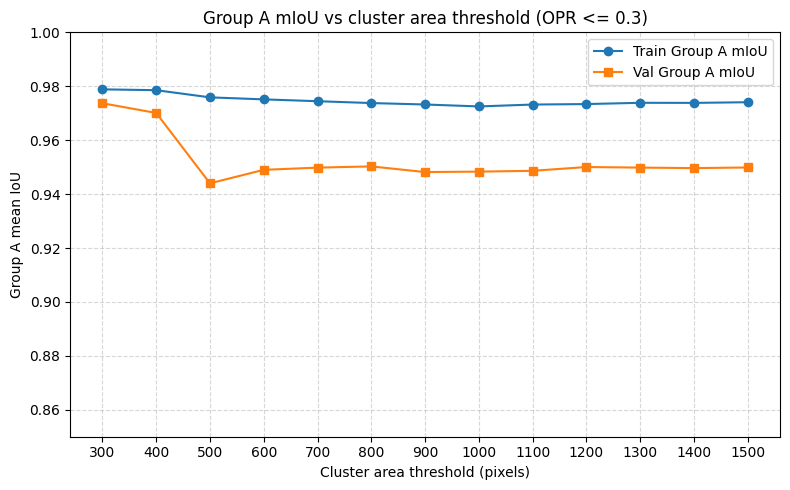

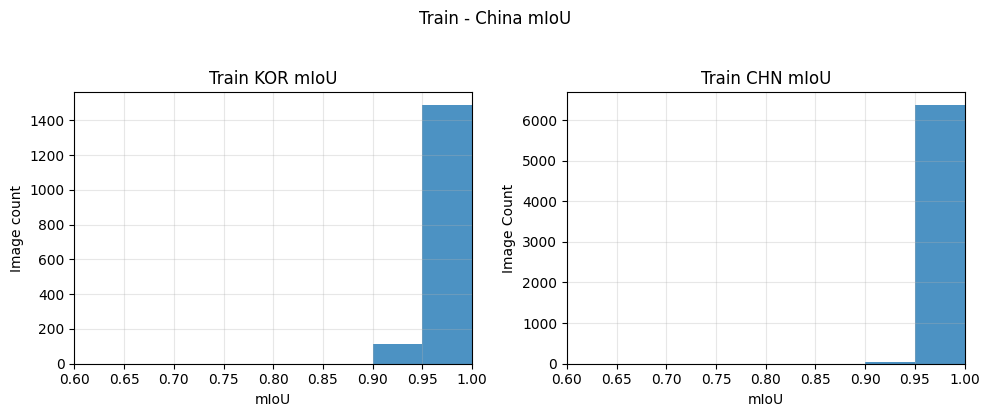

[12:23:15.106] [Val] KOR 이미지 219개, mIoU = 0.9608 된다.
[12:23:15.109] [Val] CHN 이미지 781개, mIoU = 0.9607 된다.


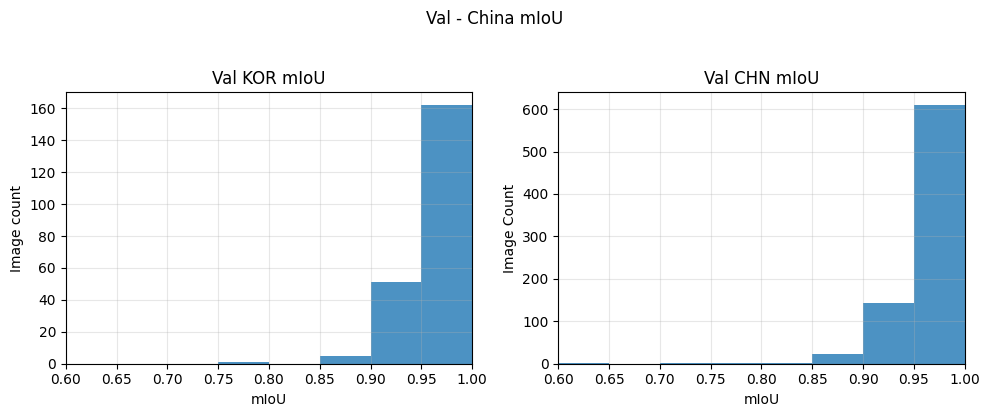

[12:23:15.528] Saved CHN vs KOR mIoU plot to: /content/CHNvsKOR.png
[12:23:15.531] 
[12:23:15.533] ===== Oversampling target (Train, cluster-based) =====
[12:23:15.535] [Train] OPR <= 0.30 & area <= 700 에서
[12:23:15.537] [Train] 작은 클러스터 수가 더 많은 Group A 이미지 수: 343개 한다.
[12:23:15.539] [Train] 해당 이미지 파일 이름 목록:
[12:23:15.541] 
[12:23:15.543] [Train] 원본 train 개수: 8000개 한다.
[12:23:15.545] [Train] oversample 대상 343개 × ratio 3 → 추가 1029개 샘플 된다.
[12:23:15.546] [Train] 오버샘플링 이후 이론상 전체 train 개수: 9029개 한다.
[12:23:15.548] ========================================


'[12:23:15.548] ========================================'

<Figure size 640x480 with 0 Axes>

In [ ]:
'''
 Data Oversampling 분석 (best_model 기반)
 - 이미 위에서 정의한 것들:
   MultiModalDataset, MultiModalTransUNet_ViTpretrained,
   log_line, seed_worker, g, device 등을 그대로 사용
'''

# ====== Training / Validation DataLoader (shuffle=False) ======
TRAIN_BASE = "/content/Training"
VAL_BASE   = "/content/Validation"

train_dataset = MultiModalDataset(base_dir=TRAIN_BASE, transform_geometry=None, transform_appearance=None)
val_dataset   = MultiModalDataset(base_dir=VAL_BASE, transform_geometry=None, transform_appearance=None)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=g,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=g,
)

log_line(f"[Oversampling] Train samples: {len(train_dataset)}")
log_line(f"[Oversampling] Val samples  : {len(val_dataset)}")

# ====== 모델 생성 & 가중치 로드 (n_classes=2) ======
ckpt_path = "/content/drive/MyDrive/runs/base_model.pt"
log_line(f"[Oversampling] Loading checkpoint from: {ckpt_path}")

model = MultiModalTransUNet_ViTpretrained(n_classes=2).to(device)
state_dict = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state_dict)
model.to(device)
model.eval()
log_line("[Oversampling] Checkpoint loaded 한다.")

# ====== Positive Pixel Ratio vs IoU 계산 (Train / Val 공용) ======
@torch.no_grad()
def eval_posratio_vs_iou(loader, name=""):
    pos_list = []
    iou_list = []

    pbar = tqdm(loader, desc=f"Eval ({name}) pos_ratio vs IoU")
    for sn10, air, gems, label in pbar:
        sn10  = sn10.to(device)
        air   = air.to(device)
        gems  = gems.to(device)
        label = label.to(device)

        logits = model(sn10, air, gems)

        ## 예측 이진 마스크 (foreground=1 기준)
        preds_class = torch.argmax(logits, dim=1, keepdim=True)
        preds = preds_class.float()

        gt = (label > 0.5).float()
        
        pos_ratio_batch = gt.mean(dim=(1, 2, 3))  # [B]
        pos_list.extend(pos_ratio_batch.cpu().tolist())

        inter = (preds * gt).sum(dim=(1, 2, 3))
        union = preds.sum(dim=(1, 2, 3)) + gt.sum(dim=(1, 2, 3)) - inter
        iou_batch = (inter + 1e-7) / (union + 1e-7)

        iou_list.extend(iou_batch.cpu().tolist())

    pos_array = np.array(pos_list, dtype=np.float32)
    iou_array = np.array(iou_list, dtype=np.float32)
    mean_iou = float(iou_array.mean()) if len(iou_array) > 0 else 0.0
    log_line(f"[{name}] mean IoU (per-image 평균): {mean_iou:.4f}")
    return pos_array, iou_array, mean_iou

# ====== Train / Val pos_ratio & IoU 계산 ======
pos_ratios_train, ious_train, mean_iou_train = eval_posratio_vs_iou(train_loader, name="Train")
pos_ratios_val,   ious_val,   mean_iou_val   = eval_posratio_vs_iou(val_loader,   name="Val")

# ====== bin별 mIoU 계산 함수 ======
def compute_bin_stats(pos_array, iou_array, bins):
    bin_idx = np.digitize(pos_array, bins) - 1  # 0 ~ B-1
    n_bin = len(bins) - 1
    sums   = np.zeros(n_bin, dtype=np.float64)
    counts = np.zeros(n_bin, dtype=np.int64)

    for idx, iou in zip(bin_idx, iou_array):
        if 0 <= idx < n_bin:
            sums[idx]   += iou
            counts[idx] += 1

    mean_iou = np.zeros(n_bin, dtype=np.float64)
    valid = counts > 0
    mean_iou[valid] = sums[valid] / counts[valid]

    bin_centers = (bins[:-1] + bins[1:]) / 2.0
    return bin_centers, mean_iou, counts

# ====== bin 설정 ======
num_bins = 50
min_ratio = 0.0

max_ratio = 0.0
if len(pos_ratios_train) > 0:
    max_ratio = max(max_ratio, float(pos_ratios_train.max()))
if len(pos_ratios_val) > 0:
    max_ratio = max(max_ratio, float(pos_ratios_val.max()))
if max_ratio <= 0:
    max_ratio = 1.0

bins = np.linspace(min_ratio, max_ratio, num_bins + 1)

bin_centers_tr, train_bin_miou, train_bin_cnt = compute_bin_stats(pos_ratios_train, ious_train, bins)
bin_centers_vl, val_bin_miou,   val_bin_cnt   = compute_bin_stats(pos_ratios_val,   ious_val,   bins)

# ====== 히스토그램(밑변) + mIoU(윗변) 그래프 ======
hist_combo_path = os.path.join(save_dir, "train_val_posratio_hist_mIoU.png")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
fig.suptitle("Train / Val: pos_ratio histogram + mean IoU", fontsize=14)

# ====== Training ======
ax_tr = axes[0]
ax_tr2 = ax_tr.twinx()

ax_tr.hist(pos_ratios_train, bins=bins, color="tab:blue", alpha=0.5, edgecolor="black")
ax_tr.set_xlabel("Positive Pixel Ratio (GT=1)")
ax_tr.set_ylabel("Image Count")
ax_tr.set_title(f"Training (mean IoU={mean_iou_train:.3f})")

ax_tr2.plot(bin_centers_tr, train_bin_miou, marker="o", linestyle="-", color="tab:orange")
ax_tr2.set_ylabel("Mean IoU per bin")
ax_tr2.set_ylim(0.95, 1.0)   # 0.95~1.0 구간만

# ====== Validation ======
ax_vl = axes[1]
ax_vl2 = ax_vl.twinx()

ax_vl.hist(pos_ratios_val, bins=bins, color="tab:blue", alpha=0.5, edgecolor="black")
ax_vl.set_xlabel("Positive Pixel Ratio (GT=1)")
ax_vl.set_ylabel("Image Count")
ax_vl.set_title(f"Validation (mean IoU={mean_iou_val:.3f})")

ax_vl2.plot(bin_centers_vl, val_bin_miou, marker="o", linestyle="-", color="tab:orange")
ax_vl2.set_ylabel("Mean IoU per bin")
ax_vl2.set_ylim(0.92, 1.0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(hist_combo_path, dpi=150)
plt.close()

print(f"Train/Val hist+mIoU graph saved to: {hist_combo_path}")

# ====== bin 통계도 CSV로 저장 ======
hist_csv_path = os.path.join(save_dir, "train_val_posratio_bin_mIoU.csv")
hist_df = pd.DataFrame({
    "bin_left":       bins[:-1],
    "bin_right":      bins[1:],
    "bin_center":     bin_centers_tr,
    "train_count":    train_bin_cnt,
    "train_mean_iou": train_bin_miou,
    "val_count":      val_bin_cnt,
    "val_mean_iou":   val_bin_miou,
})
hist_df.to_csv(hist_csv_path, index=False)
print(f"Histogram stats saved to: {hist_csv_path}")

bar_path = os.path.join(save_dir, "train_val_posratio_bin_meanIoU_bar.png")
bin_centers = bin_centers_tr  # train/val 공통

fig, ax = plt.subplots(figsize=(10, 4))
fig.suptitle("Object Pixel Ratio vs mIoU (Train vs Val)", fontsize=18)

base_width   = (bins[1] - bins[0]) * 1.0
train_width  = base_width
val_width    = base_width * 0.6

ax.bar(
    bin_centers,
    train_bin_miou,
    width=train_width,
    color="tab:blue",
    alpha=0.5,
    edgecolor="black",
    label=f"Train (mean IoU={mean_iou_train:.4f})"
)

ax.bar(
    bin_centers,
    val_bin_miou,
    width=val_width,
    color="tab:orange",
    alpha=0.8,
    edgecolor="black",
    label=f"Val (mean IoU={mean_iou_val:.4f})"
)

ax.set_xlabel("Object Pixel Ratio (GT=1)")
ax.set_ylabel("Mean IoU")
ax.set_ylim(0.94, 1.0)
ax.grid(axis="y", linestyle="--", alpha=0.5)

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.18),
    ncol=2,
    frameon=False,
)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.savefig(bar_path, dpi=150)
plt.close()

print(f"Train/Val pos_ratio-bin mIoU bar plot saved to: {bar_path}")
print("Done 한다.")

# ====== pos_ratio 기준(0.3)으로 Train/Val mIoU 비교 ======
threshold_split = 0.3  # 기준값

def report_miou_by_posratio(pos_array, iou_array, threshold, name=""):
    pos_array = np.asarray(pos_array)
    iou_array = np.asarray(iou_array)

    mask_low  = pos_array <= threshold       # threshold 이하
    mask_high = pos_array >  threshold       # threshold 초과

    def safe_mean(x):
        return float(x.mean()) if x.size > 0 else None

    miou_low  = safe_mean(iou_array[mask_low])
    miou_high = safe_mean(iou_array[mask_high])

    n_low  = int(mask_low.sum())
    n_high = int(mask_high.sum())

    if miou_low is not None:
        log_line(f"[{name}] pos_ratio <= {threshold:.2f} : mIoU={miou_low:.4f} ({n_low} images) 한다.")
    else:
        log_line(f"[{name}] pos_ratio <= {threshold:.2f} 인 이미지는 없다 한다.")

    if miou_high is not None:
        log_line(f"[{name}] pos_ratio  > {threshold:.2f} : mIoU={miou_high:.4f} ({n_high} images) 한다.")
    else:
        log_line(f"[{name}] pos_ratio  > {threshold:.2f} 인 이미지는 없다 한다.")
    log_line("")


report_miou_by_posratio(pos_ratios_train, ious_train, threshold_split, name="Train")
report_miou_by_posratio(pos_ratios_val,   ious_val,   threshold_split, name="Val")

# ====== 클러스터 기반 A/B 그룹 mIoU 계산 함수 ======
def report_miou_by_cluster(
    base_dir,
    pos_array,
    iou_array,
    posratio_threshold=0.3,
    area_thresholds=(300, 1500),
    name="",
):

    pos_array = np.asarray(pos_array)
    iou_array = np.asarray(iou_array)

    if os.path.normpath(base_dir).split(os.sep)[-1] == "Training":
        sub_title_label = "label/TL_SN10"
    else:
        sub_title_label = "label/VL_SN10"
    label_dir = os.path.join(base_dir, sub_title_label)

    label_files = natsort.natsorted(os.listdir(label_dir))

    if len(label_files) != len(pos_array):
        raise ValueError(
            f"[{name}] 라벨 파일 수({len(label_files)})와 pos_array 길이({len(pos_array)})가 다르다."
        )

    ## area_threshold 별로 A/B 그룹 IoU 저장용 딕셔너리 초기화
    stats = {}
    for thr in area_thresholds:
        stats[thr] = {
            "A_ious": [],     # 작은 클러스터가 더 많은 이미지 IoU
            "B_ious": [],     # 그 외 이미지 IoU
            "A_indices": [],  # 작은 클러스터가 더 많은 이미지 인덱스
            "B_indices": [],  # 그 외 이미지 인덱스
        }

    ## OPR <= threshold 인 이미지 수
    mask_low = pos_array <= posratio_threshold
    n_low = int(mask_low.sum())

    log_line(f"[{name}] Object Pixel Ratio <= {posratio_threshold:.2f} 인 이미지 수: {n_low}개 한다.")

    ## 각 이미지에 대해 클러스터 분석하여 A/B 그룹 분류
    for idx, (pos, iou) in enumerate(zip(pos_array, iou_array)):
        if pos > posratio_threshold:
            continue  

        label_path = os.path.join(label_dir, label_files[idx])

        mask = io.imread(label_path)
        mask = np.where(mask == 10, 1, mask)
        mask = np.where(mask == 90, 0, mask)
        mask = (mask == 1).astype(np.uint8)  # 0/1

        labeled = measure.label(mask, connectivity=1)
        props = measure.regionprops(labeled)

        if len(props) > 0:
            areas = np.array([p.area for p in props], dtype=np.int32)
        else:
            areas = np.zeros((0,), dtype=np.int32)  # 클러스터가 전혀 없는 경우

        ## 각 area_threshold 에 대해 A/B 그룹 분류
        for thr in area_thresholds:
            if areas.size > 0:
                small_cnt = (areas <= thr).sum()
                big_cnt   = (areas >  thr).sum()
            else:
                small_cnt, big_cnt = 0, 0

            ## "해당 이미지의 클러스터 개수 중에 thr 이하 개수가 더 높은 경우 A"
            if small_cnt > big_cnt:
                stats[thr]["A_ious"].append(float(iou))
                stats[thr]["A_indices"].append(idx)  
            else:
                stats[thr]["B_ious"].append(float(iou))
                stats[thr]["B_indices"].append(idx)  

    summary = {
        "thresholds": [],
        "A_miou": [],
        "A_count": [],
        "B_miou": [],
        "B_count": [],
        "A_indices_by_thr": {},  # thr -> [idx, ...]
        "B_indices_by_thr": {},  # thr -> [idx, ...]
    }

    for thr in area_thresholds:
        A_ious = np.array(stats[thr]["A_ious"], dtype=np.float32)
        B_ious = np.array(stats[thr]["B_ious"], dtype=np.float32)

        A_mean = float(A_ious.mean()) if A_ious.size > 0 else np.nan
        B_mean = float(B_ious.mean()) if B_ious.size > 0 else np.nan

        summary["thresholds"].append(thr)
        summary["A_miou"].append(A_mean)
        summary["A_count"].append(int(A_ious.size))
        summary["B_miou"].append(B_mean)
        summary["B_count"].append(int(B_ious.size))

        summary["A_indices_by_thr"][thr] = stats[thr]["A_indices"]
        summary["B_indices_by_thr"][thr] = stats[thr]["B_indices"]

        log_line(f"\n[{name}] OPR <= {posratio_threshold:.2f} & area <= {thr} 기준 A/B 그룹 mIoU 결과 한다.")

        if A_ious.size > 0:
            log_line(
                f"  - Group A (클러스터 면적 <= {thr} 픽셀인 작은 클러스터 수가 더 많은 이미지)"
                f" : mIoU={A_mean:.4f} ({A_ious.size} images) 한다."
            )
        else:
            log_line(f"  - Group A : 해당 조건을 만족하는 이미지가 없다 한다.")

        if B_ious.size > 0:
            log_line(
                f"  - Group B (그 외 이미지)"
                f" : mIoU={B_mean:.4f} ({B_ious.size} images) 한다."
            )
        else:
            log_line(f"  - Group B : 해당 조건을 만족하는 이미지가 없다 한다.")
    log_line("")

    return summary

# ====== 국가별(KOR / CHN) IoU 히스토그램 ======
def plot_iou_hist_by_country(base_dir, iou_array, name=""):
    base_last = os.path.normpath(base_dir).split(os.sep)[-1]
    if base_last == "Training":
        sub_title_label = "label/TL_SN10"
    else:
        sub_title_label = "label/VL_SN10"

    label_dir = os.path.join(base_dir, sub_title_label)

    label_files = natsort.natsorted(os.listdir(label_dir))

    if len(label_files) != len(iou_array):
        raise ValueError(
            f"[{name}] 라벨 파일 수({len(label_files)})와 IoU 배열 길이({len(iou_array)})가 다르다."
        )

    iou_array = np.asarray(iou_array, dtype=np.float32)

    ## 파일명에서 KOR / CHN 태그 추출
    countries = []
    for fname in label_files:
        if "KOR" in fname:
            countries.append("KOR")
        elif "CHN" in fname:
            countries.append("CHN")
        else:
            countries.append("OTHER")
    countries = np.array(countries)

    kor_iou = iou_array[countries == "KOR"]
    chn_iou = iou_array[countries == "CHN"]

    if kor_iou.size > 0:
        log_line(f"[{name}] KOR 이미지 {kor_iou.size}개, mIoU = {kor_iou.mean():.4f} 된다.")
    else:
        log_line(f"[{name}] KOR 이미지는 없다 한다.")

    if chn_iou.size > 0:
        log_line(f"[{name}] CHN 이미지 {chn_iou.size}개, mIoU = {chn_iou.mean():.4f} 된다.")
    else:
        log_line(f"[{name}] CHN 이미지는 없다 한다.")

    # ====== 히스토그램 ======
    bins = np.linspace(0.0, 1.0, 21)  # 0~1 범위 0.05 간격

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    if kor_iou.size > 0:
        plt.hist(kor_iou, bins=bins, alpha=0.8)
    plt.title(f"{name} KOR mIoU")
    plt.xlabel("mIoU")
    plt.ylabel("Image count")
    plt.grid(True, alpha=0.3)
    plt.xlim(0.6, 1.0)

    plt.subplot(1, 2, 2)
    if chn_iou.size > 0:
        plt.hist(chn_iou, bins=bins, alpha=0.8)
    plt.title(f"{name} CHN mIoU")
    plt.xlabel("mIoU")
    plt.ylabel("Image Count")
    plt.grid(True, alpha=0.3)
    plt.xlim(0.6, 1.0)

    plt.suptitle(f"{name} - China mIoU", y=1.03)
    plt.tight_layout()
    plt.show()

    return kor_iou, chn_iou

# ====== 클러스터 기반 A/B 그룹 mIoU 출력 및 통계 수집 ======
AREA_THRESHOLDS = (300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500)

train_cluster_stats = report_miou_by_cluster(
    base_dir=TRAIN_BASE,
    pos_array=pos_ratios_train,
    iou_array=ious_train,
    posratio_threshold=threshold_split,   # 0.3
    area_thresholds=AREA_THRESHOLDS,
    name="Train",
)

val_cluster_stats = report_miou_by_cluster(
    base_dir=VAL_BASE,
    pos_array=pos_ratios_val,
    iou_array=ious_val,
    posratio_threshold=threshold_split,   # 0.3
    area_thresholds=AREA_THRESHOLDS,
    name="Val",
)

# ====== Group A mIoU vs threshold 시각화 ======
thr_arr = np.array(train_cluster_stats["thresholds"], dtype=np.float32)
train_A_miou = np.array(train_cluster_stats["A_miou"], dtype=np.float32)
val_A_miou   = np.array(val_cluster_stats["A_miou"],   dtype=np.float32)

plt.figure(figsize=(8, 5))
plt.plot(thr_arr, train_A_miou, marker="o", label="Train Group A mIoU")
plt.plot(thr_arr, val_A_miou,   marker="s", label="Val Group A mIoU")

plt.xlabel("Cluster area threshold (pixels)")
plt.ylabel("Group A mean IoU")
plt.title("Group A mIoU vs cluster area threshold (OPR <= 0.3)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(thr_arr)
plt.ylim(0.85, 1.0)
plt.legend()
plt.tight_layout()

out_fig_path = "/content/groupA_mIoU_vs_area.png"
plt.savefig(out_fig_path, dpi=300)
log_line(f"Saved Group A mIoU plot to: {out_fig_path}")

# ====== Train/Val 국가별 IoU 히스토그램 ======
plot_iou_hist_by_country(TRAIN_BASE, ious_train, name="Train")
plot_iou_hist_by_country(VAL_BASE,   ious_val,   name="Val")

out_fig_path = "/content/CHNvsKOR.png"
plt.savefig(out_fig_path, dpi=300)
log_line(f"Saved CHN vs KOR mIoU plot to: {out_fig_path}")

# ====== Oversampling (클러스터 기반) ======
oversample_threshold = 700
oversample_ratio     = 3

if oversample_threshold not in AREA_THRESHOLDS:
    raise ValueError(
        f"oversample_threshold={oversample_threshold} 는 "
        f"AREA_THRESHOLDS {AREA_THRESHOLDS} 안에 있어야 한다."
    )

## Train에서 oversample 대상이 될 인덱스 (Group A, OPR<=0.3 & 작은 클러스터 우세)
A_indices  = train_cluster_stats["A_indices_by_thr"][oversample_threshold]
low_indices = np.array(A_indices, dtype=np.int64)
low_count   = int(low_indices.size)

log_line("")
log_line("===== Oversampling target (Train, cluster-based) =====")
log_line(f"[Train] OPR <= {threshold_split:.2f} & area <= {oversample_threshold} 에서")
log_line(f"[Train] 작은 클러스터 수가 더 많은 Group A 이미지 수: {low_count}개 한다.")
log_line("[Train] 해당 이미지 파일 이름 목록:")

# ====== 실제 oversampled index 리스트 생성 ======
orig_indices = np.arange(len(train_dataset), dtype=np.int64)

if low_count > 0:
    extra_indices      = np.repeat(low_indices, oversample_ratio)
    oversampled_indices = np.concatenate([orig_indices, extra_indices])
else:
    oversampled_indices = orig_indices  # 대상이 없으면 원본 그대로

log_line("")
orig_train_n  = len(orig_indices)
extra_samples = len(oversampled_indices) - orig_train_n
new_total_n   = len(oversampled_indices)

log_line(f"[Train] 원본 train 개수: {orig_train_n}개 한다.")
log_line(f"[Train] oversample 대상 {low_count}개 × ratio {oversample_ratio} → 추가 {extra_samples}개 샘플 된다.")
log_line(f"[Train] 오버샘플링 이후 이론상 전체 train 개수: {new_total_n}개 한다.")
log_line("========================================")


In [14]:
runtime.unassign()